In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import misc

from poppy_roman_cgi_phasec import cgi

from importlib import reload
import copy

reload(cgi)
spcw = cgi.CGI(cgi_mode='spc-wide')

wavelength_c = spcw.wavelength_c

nlam = 3
bandwidth = 0.1
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
lam_array_broad = np.linspace( minlam, maxlam, nlam )

iwa = 5.4
owa = 20

data_dir = Path('/groups/douglase/kians-data-files/poppy-cupy-tests-data')
# misc.save_pickle(data_dir/'hlc_cpu_wfs_mono', wfs)

In [7]:
poppy.conf.use_cupy = False
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

poppy_log.disabled = True

# Test without OPDs implemented

### Monochromatic Test

Propagating wavelength 825.000 nm.
PSF calculated in 35.921s


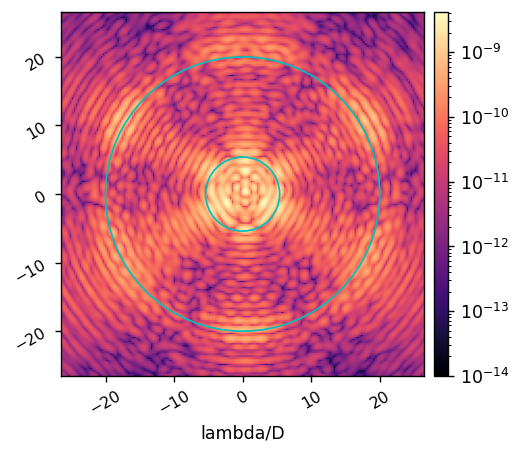

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/spcw_cpu_wfs_mono


In [8]:
spcw = cgi.CGI(cgi_mode='spc-wide', npsf=175, use_pupil_defocus=False)

wfs = spcw.calc_psf()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-14)

misc.save_pickle(data_dir/'spcw_cpu_wfs_mono', wfs)

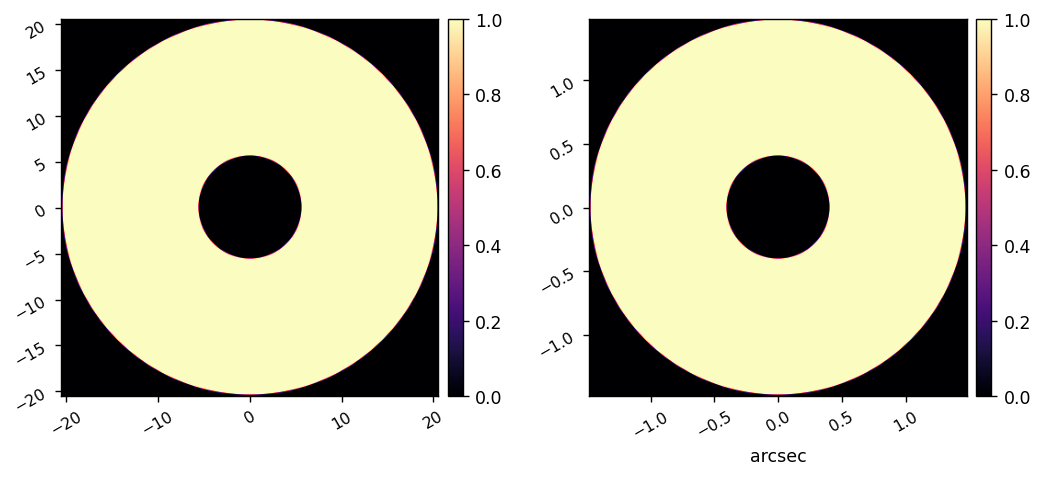

In [11]:
misc.myimshow2(spcw.FPM.amplitude, spcw.FPM.amplitude, 
               pxscl1=spcw.FPM.pixelscale_lamD, pxscl2=spcw.FPM.pixelscale)

### Broadband Test

(_calc_psf pid=74539) Propagating wavelength 783.750 nm.
(_calc_psf pid=74606) Propagating wavelength 825.000 nm.
(_calc_psf pid=74674) Propagating wavelength 866.250 nm.
(_calc_psf pid=74539) PSF calculated in 1.843s
(_calc_psf pid=74606) PSF calculated in 1.841s
(_calc_psf pid=74674) PSF calculated in 1.848s
All PSFs calculated in 4.717s
0 7.8375e-07 m
1 8.25e-07 m
2 8.662500000000001e-07 m


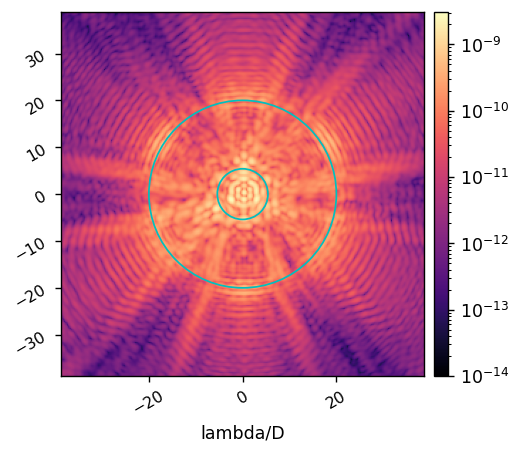

In [16]:
spcw = cgi.CGI_POPPY(cgi_mode='spc-wide', npsf=256, use_pupil_defocus=True, use_opds=False, polaxis=0)

wfs = spcw.calc_psfs(wavelengths=lam_array_broad, ncpus=16, ngpus=1/3, quiet=False)

psf_broad = 0
for i,wf in enumerate(wfs):
    print(i, wf[-1].wavelength)
    psf_broad += wf[-1].intensity/nlam
    
patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-14)

# Test with OPDs implemented

### Monochromatic Test

Propagating wavelength 825.000 nm.
PSF calculated in 0.884s


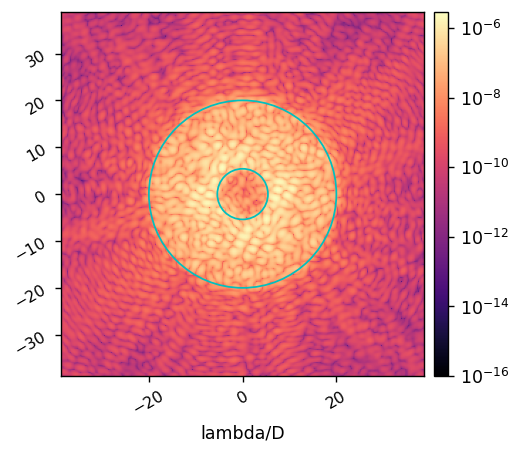

In [8]:
spcw = cgi.CGI_POPPY(cgi_mode='spc-wide', npsf=256, use_pupil_defocus=True, use_opds=True, polaxis=10)
clear_output()

wfs = spcw.calc_psf(quiet=False)

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-16)

### Broadband Test

Calculating PSF for wavelength 7.838e-07 m.
Calculating PSF for wavelength 8.250e-07 m.
Calculating PSF for wavelength 8.663e-07 m.


(_calc_psf pid=57784) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57784) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57717) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57717) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57851) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57851) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(_calc_psf pid=57784) After resampling, optic phasor shape (1088, 1088) is smaller than 

All PSFs calculated in 28.306s
0 7.8375e-07 m
1 8.25e-07 m
2 8.662500000000001e-07 m


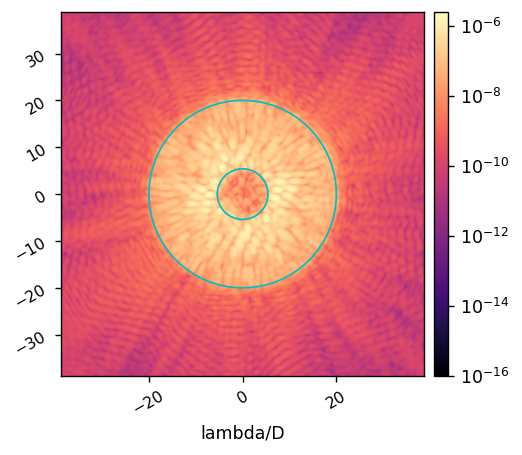

In [9]:
spcw = cgi.CGI_POPPY(cgi_mode='spc-wide', npsf=256, use_pupil_defocus=True, use_opds=True, polaxis=0)

wfs = spcw.calc_psfs(wavelengths=lam_array_broad, ncpus=16, ngpus=1/3, quiet=False)

psf_broad = 0
for i,wf in enumerate(wfs):
    print(i, wf[-1].wavelength)
    psf_broad += wf[-1].intensity/nlam
    
patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches, vmin=1e-16)

# Perform speed tests with different packages.

In [ ]:
n_itr = 1 # number of iterations to calculate a PSF for each case

poppy.conf.use_cupy = False
poppy.conf.use_mkl = False
poppy.conf.use_fftw = False

In [ ]:
times_mono_1 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=False, polaxis=0)
    wfs = hlc.calc_psf(quiet=True)
    times_mono_1.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)
    
times_broad_1 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=False, polaxis=0)
    wfs = hlc.calc_psfs(wavelengths=lam_array_broad, ncpus=22, ngpus=1/2, quiet=True)
    times_broad_1.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)

times_mono_2 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)
    wfs = hlc.calc_psf(quiet=True)
    times_mono_2.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)

times_broad_2 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)
    wfs = hlc.calc_psfs(wavelengths=lam_array_broad, ncpus=22, ngpus=1/2, quiet=True)
    times_broad_2.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)
